# Dynamic Time Warping

(This notebook is based on the Python Notebooks from Meinard Müller's [Fundamentals of Music Processing](https://www.audiolabs-erlangen.de/resources/MIR/FMP/C0/C0.html) book.)

Dynamic time warping (DWT) is a dynamic programming algorithm to find the **optimal** alignment between to time-dependent sequences.

In this notebook we will explore how this algorithm works.

## Features, Feature Spaces

Let us consider two $\mathbf{X} = \{\mathbf{x}_1, \dots \mathbf{x}_N\}$ and $\mathbf{Y} = \{\mathbf{y}_1, \dots, \mathbf{y}_M\}$ for which we want to find an aligment.

* This sequences could be discrete signals, feature sequences, sequences of characters, etc.

* The elements $\mathbf{x}_n$, $\mathbf{y}_m$ belong to the same **feature space** $\mathcal{F}$. For the purposes of this class, let us consider these elements as $K$-dimensional real-vectors, i.e., $\mathbf{x}, \mathbf{y} \in \mathbb{R}^K$ although they can other kind of objects (e.g., characters in an alphabet).

An important aspect of this feature space is that it allows us to use *quantitive measures* of how similar the elements of sequence $\mathbf{X}$ are to the elements in sequence $\mathbf{Y}$. We will come to this point in a moment.

For now, let us generate some test data that we can play with!

In [9]:
# Let's start by importing some stuff
import numpy as np
from helper import generate_example_sequences, plot_alignment
from matplotlib import patches, lines, pyplot as plt
from scipy.spatial.distance import cdist

%config InlineBackend.figure_format ='retina'

The following code generates example pairs of related sequences. Sequence $\mathbf{X}$ are samples of a K-dimensional space and sequence $\mathbf{Y}$ is a non-constant "time-streched" version of X with some noise added.

[[  6.03459592   4.51662252  -9.35212385   7.16927758   1.45198859]
 [ -8.31614324  -0.3712868    0.50011414 -10.43182506  -2.13446357]
 [-11.17062468   0.78866207   0.80203463 -11.21760983  -0.02893794]
 [  5.74104067   3.69418418 -10.77445104   6.54860372  -1.1987222 ]
 [  5.9125696    4.82486943  -9.34123189   7.15537272  -1.10349051]
 [-11.65738826  -0.80587255   1.69646738 -10.33607377  -0.491855  ]
 [ -2.36254861   4.5632915    0.77690128   1.37696403   6.92595159]
 [ -1.87902718   3.37428764   1.79351532   2.71415109   4.72965268]
 [  5.92167982   5.34632935  -7.81471624   6.29266296   1.71734457]
 [ -0.9940463    3.42004242   0.57036762   1.36412445   6.7919375 ]
 [ -1.32563813   2.94194665   0.32687344   3.43284361   7.47662145]
 [-11.76906084  -0.03918706  -0.07582758 -10.09175955   1.04930463]
 [-11.62559027   0.74700654  -0.01908564 -10.75663569  -1.37947697]
 [  5.53383996   3.77204026 -10.66365364   8.55517319   1.1059543 ]
 [ -2.13564083   2.99621435   1.35967887   1.920

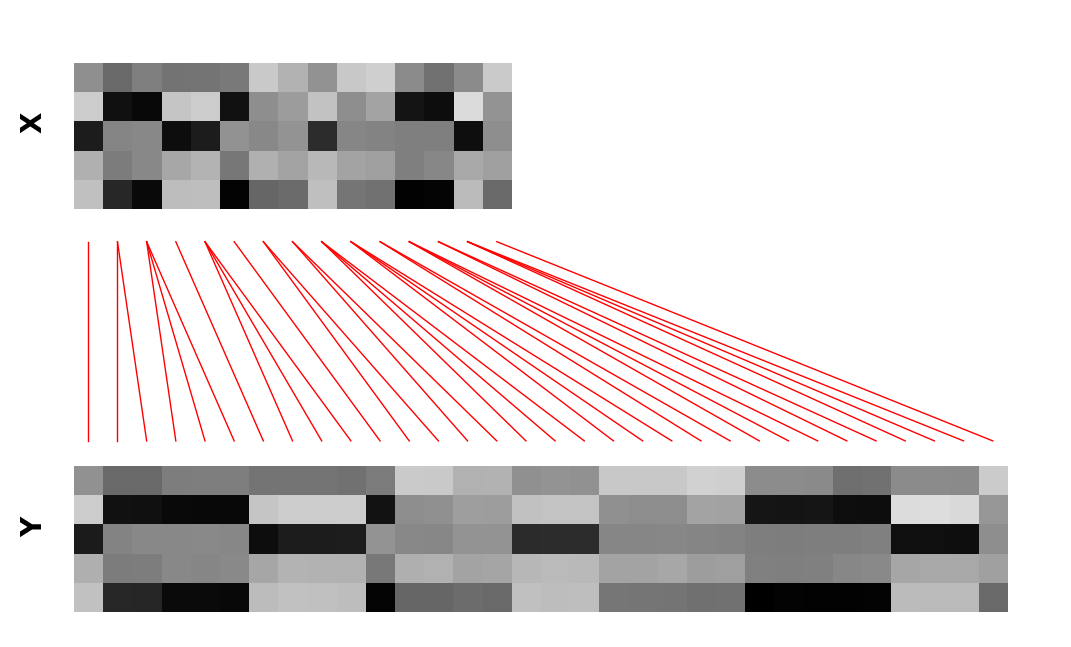

In [17]:
# This is a helper method to generate sample sequences 
# (see helper.py for documentation)

# lenght of the "reference" sequence
lenX = 15

# dimensionality of the feature space
K = 5

# This method generates an example sequence
X, Y, gr_path = generate_example_sequences(
    lenX=lenX, 
    centers=3, 
    n_features=K,
    maxreps=4, 
    minreps=1, 
    noise_scale=0.1
)
print(X, Y, gr_path)
# Let us plot the data to see how it looks like!
plot_alignment(X, Y, gr_path)

## Comparing the similarity of the features: Local cost distance

We would like to know how to compare the elements in $\mathbf{X}$ and $\mathbf{Y}$. For this we use a local distance function, which can be any distance(-like) function that is small when $\mathbf{x}_i$ is *similar* to $\mathbf{y}_j$.

Which distance to use depends on the problem at hand, although usual starting points are the Euclidean and the Manhattan ($L_1$) distances.

Using this local distance, we can compare the elements in both sequences by comparing the pairwise distance of all elements in $\mathbf{X}$ and $\mathbf{Y}$. This will result in a matrix $\mathbf{C}$, where the element $c_{ij}$ is given by

$$c_{ij} = \text{distance}(\mathbf{x}_i, \mathbf{y}_j)$$

In [3]:
def pairwise_distance_matrix(
    X: np.ndarray, 
    Y: np.ndarray, 
    metric: str = 'euclidean'
) -> np.ndarray:
    """
    Compute pairwise distance matrix of two sequences
    
    Parameters
    ----------
    X : np.ndarray
        A 2D array with size (n_observations, n_features)
    Y : np.ndarray
        A 2D array with size (m_observations, n_features)
    metric: str
        A string defining a metric (see possibilities 
        in scipy.spatial.distance.cdist)

    Returns
    -------
    C : np.ndarray
        Pairwise cost matrix
    """
    if X.ndim == 1:
        X, Y = np.atleast_2d(X, Y)
        X = X.T
        Y = Y.T
    C = cdist(X, Y, metric=metric)
    return C

Let's visualize the pairwise cost matrix

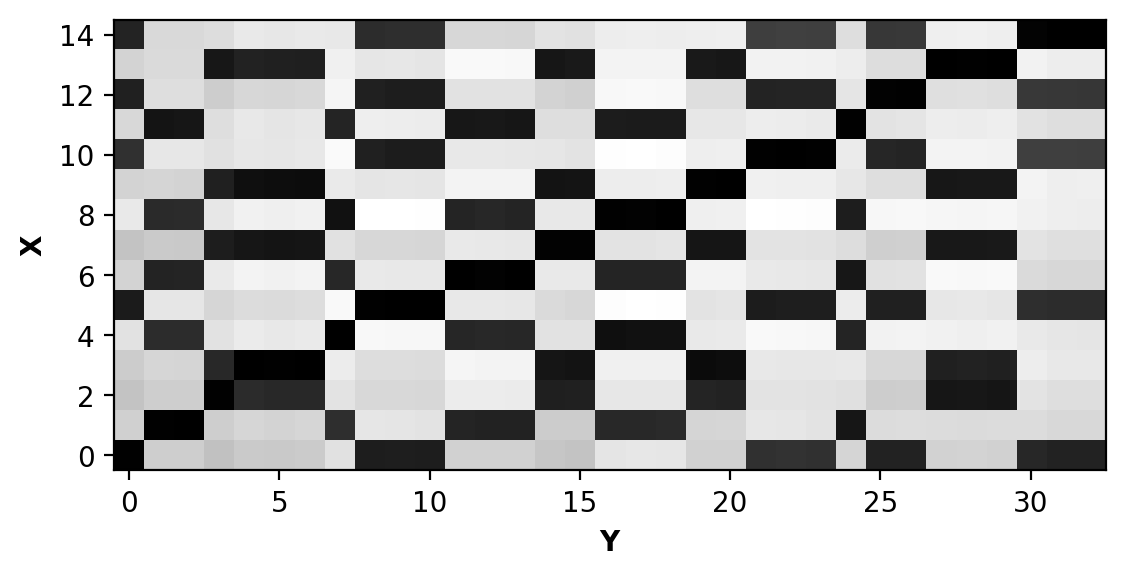

In [4]:
# Visualize cost matrix
C = pairwise_distance_matrix(X, Y)
plt.imshow(C, origin='lower', aspect='equal', cmap='gray')
plt.xlabel(r'$\mathbf{Y}$')
plt.ylabel(r'$\mathbf{X}$')
plt.show()

Text(0, 0.5, 'Sequence X')

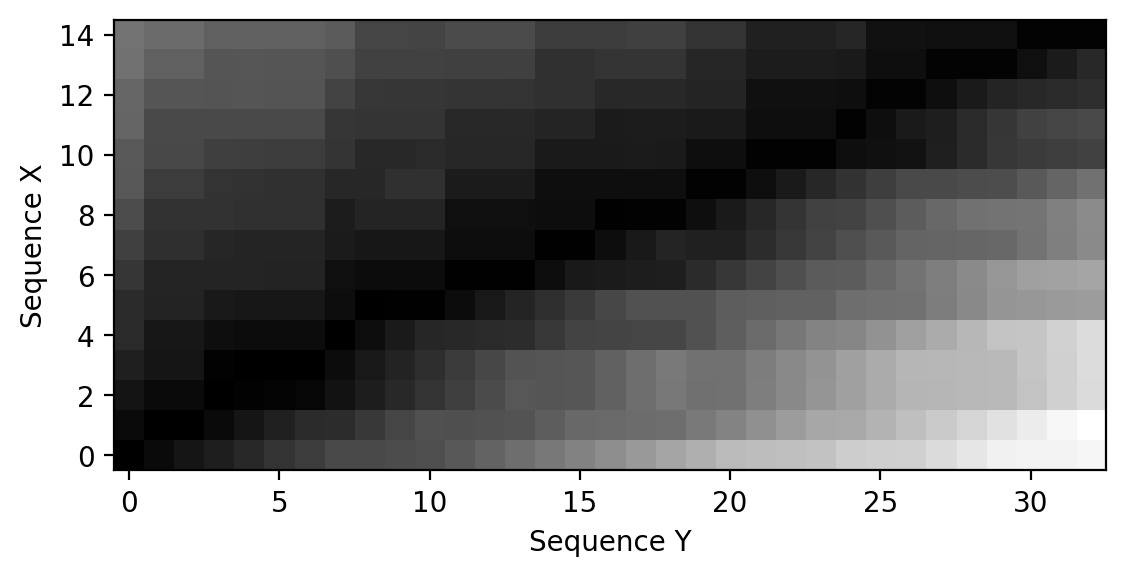

In [5]:
def accumulated_cost_matrix(C: np.ndarray) -> np.ndarray:
    """
    Dynamic time warping cost matrix from a pairwise distance matrix

    Parameters
    ----------
    D : double array
        Pairwise distance matrix (computed e.g., with `cdist`).

    Returns
    -------
    D : np.ndarray
        Accumulated cost matrix
    """
    N = C.shape[0]
    M = C.shape[1]
    D = np.zeros((N, M))
    D[0, 0] = C[0, 0]
    for n in range(1, N):
        D[n, 0] = D[n-1, 0] + C[n, 0]
    for m in range(1, M):
        D[0, m] = D[0, m-1] + C[0, m]
    for n in range(1, N):
        for m in range(1, M):
            D[n, m] = C[n, m] + min(D[n-1, m], D[n, m-1], D[n-1, m-1])
    return D

D = accumulated_cost_matrix(C) 

# Visualize accumulated cost matrix
plt.imshow(D, origin='lower', aspect='equal', cmap='gray')
plt.xlabel('Sequence Y')
plt.ylabel('Sequence X')

In [6]:
def optimal_warping_path(D):
    """
    Compute the warping path given an accumulated cost matrix

    Parameters
    ----------
    D: np.ndarray
        Accumulated cost Matrix
    
    Returns
    -------
    P: np.ndarray
        Optimal warping path
    """
    N = D.shape[0]
    M = D.shape[1]
    n = N - 1
    m = M - 1
    P = [(n, m)]
    while n > 0 or m > 0:
        if n == 0:
            cell = (0, m - 1)
        elif m == 0:
            cell = (n - 1, 0)
        else:
            val = min(D[n-1, m-1], D[n-1, m], D[n, m-1])
            if val == D[n-1, m-1]:
                cell = (n-1, m-1)
            elif val == D[n-1, m]:
                cell = (n-1, m)
            else:
                cell = (n, m-1)
        P.append(cell)
        (n, m) = cell
    P.reverse()
    return np.array(P)
        
P = optimal_warping_path(D)


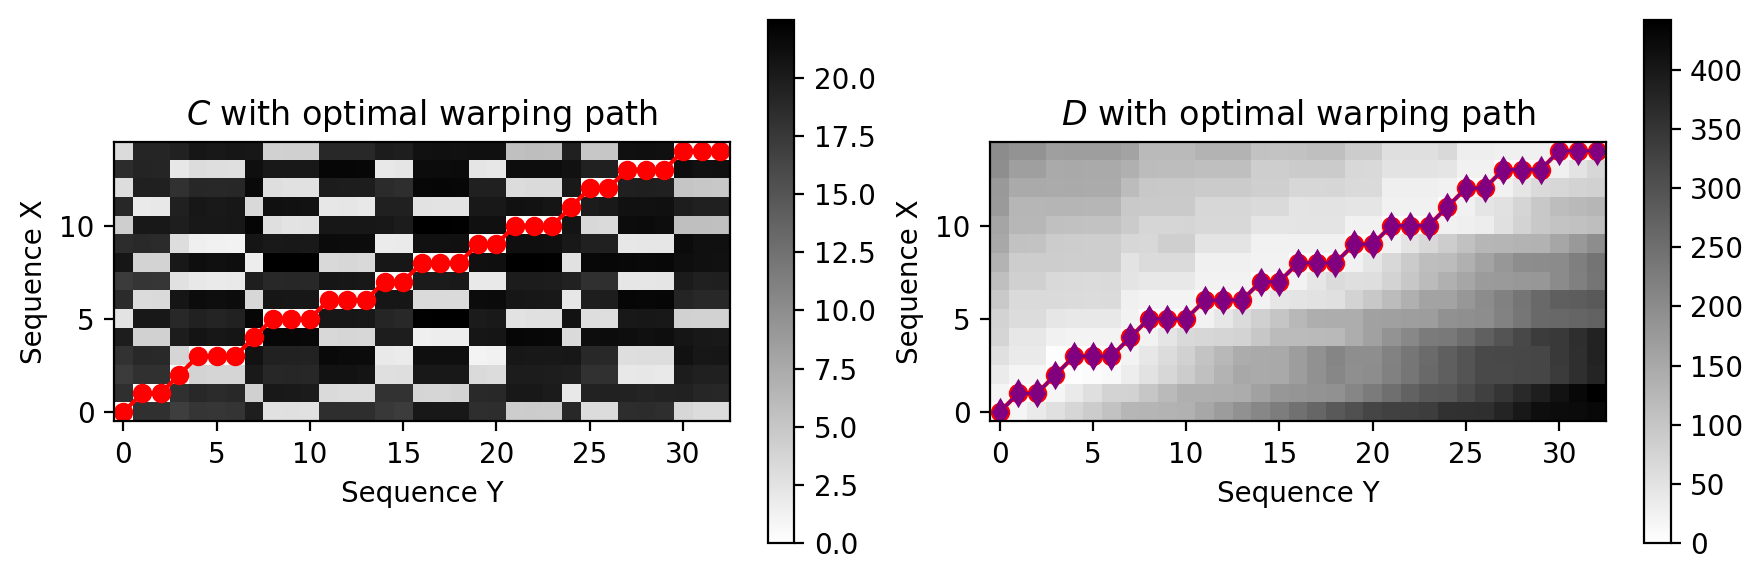

In [7]:
plt.figure(figsize=(9, 3))
plt.subplot(1, 2, 1)
plt.imshow(C, cmap='gray_r', origin='lower', aspect='equal')
plt.plot(P[:, 1], P[:, 0], marker='o', color='r')
plt.clim([0, np.max(C)])
plt.colorbar()
plt.title('$C$ with optimal warping path')
plt.xlabel('Sequence Y')
plt.ylabel('Sequence X')

plt.subplot(1, 2, 2)
plt.imshow(D, cmap='gray_r', origin='lower', aspect='equal')
plt.plot(P[:, 1], P[:, 0], marker='o', color='r')
plt.plot(gr_path[:, 1], gr_path[:, 0], marker='d', color='purple', linewidth=1.1)
plt.clim([0, np.max(D)])
plt.colorbar()
plt.title('$D$ with optimal warping path')
plt.xlabel('Sequence Y')
plt.ylabel('Sequence X')

plt.tight_layout()


Let's put everything together into a single function

In [8]:
def naive_dynamic_time_warping(
    X: np.ndarray, 
    Y: np.ndarray, 
    metric: str ='euclidean'
) -> (np.ndarray, float):
    """
    Naive Implementation of Vanilla Dynamic Time Warping
    
    Parameters
    ----------
    X : np.ndarray
        Array X
    Y: np.ndarray
        Array Y
    metric: string
        Scipy Metric
        
    Returns
    -------
    warping_path: np.ndarray
        The warping path for the optimal alignment.
    dtwd : float
        The dynamic time warping distance of the alignment.
    """
    # Compute pairwise distance matrix
    C = pairwise_distance_matrix(X, Y, metric=metric)
    # Compute accumulated cost matrix
    D = accumulated_cost_matrix(C)
    dtwd = D[-1, -1]
    # Get warping path
    warping_path = optimal_warping_path(D)
    return warping_path, dtwd

This naive implementation is very slow! You can only use it for aligning small sequences. For practical stuff, we are going to use the `fasdtw` package. This package contains an efficient implementation of vanilla DTW, as well as a faster approximation, called FastDTW.

If you want to use this package, you shold install in in your `miws22` en using pip

```
# You need to activate the conda environment first
pip install fastdtw
```

In [12]:
from fastdtw import dtw, fastdtw
from scipy.spatial import distance as sp_dist
def dynamic_time_warping(
    X: np.ndarray, 
    Y: np.ndarray, 
    metric: str = "euclidean",
) -> (np.ndarray, float):
    """
    Vanilla Dynamic Time Warping
    
    This is a more efficient implementation
    
    Parameters
    ----------
    X : np.ndarray
    Y: np.ndarray
    metric : str
       The name of the metric to use
    
    Returns
    -------
    warping_path: np.ndarray
        The warping path for the best alignment
    dtwd : float
        The dynamic time warping distance of the alignment.
    """
    # Get distance measure from scipy dist
    dist = getattr(sp_dist, metric)
    dtwd, warping_path = dtw(X, Y, dist=dist)
    
    # Make warping path a numpy array
    warping_path = np.array(warping_path)
    return warping_path, dtwd

def fast_dynamic_time_warping(
    X: np.ndarray, 
    Y: np.ndarray, 
    metric: str = "euclidean",
) -> (np.ndarray, float):
    """
     Fast Dynamic Time Warping
    
    This is an approximate solution to dynamic time warping.
    
    Parameters
    ----------
    X : np.ndarray
    Y: np.ndarray
    metric : str
       The name of the metric to use
    
    Returns
    -------
    warping_path: np.ndarray
        The warping path for the best alignment
    dtwd : float
        The dynamic time warping distance of the alignment.
    """
    
    # Get distance measure from scipy dist
    dist = getattr(sp_dist, metric)
    dtwd, warping_path = fastdtw(X, Y, dist=dist)
    
    # Make path a numpy array
    warping_path = np.array(warping_path)
    return warping_path, dtwd

# The output of the dtw 
path_naive, dtwd_naive = naive_dynamic_time_warping(X, Y)
path_optimized, dtwd_optimized = dynamic_time_warping(X, Y)
path_fdtw, dtwd_fdtw = fast_dynamic_time_warping(X, Y)

In [ ]:
plt.figure(figsize=(9, 3))
plt.subplot(1, 2, 1)
plt.imshow(C, cmap='gray_r', origin='lower', aspect='equal')
plt.plot(P[:, 1], P[:, 0], marker='o', color='r')
plt.clim([0, np.max(C)])
plt.colorbar()
plt.title('$C$ with optimal warping path')
plt.xlabel('Sequence Y')
plt.ylabel('Sequence X')

plt.subplot(1, 2, 2)
plt.imshow(D, cmap='gray_r', origin='lower', aspect='equal')
plt.plot(P[:, 1], P[:, 0], marker='o', color='r')
plt.plot(gr_path[:, 1], gr_path[:, 0], marker='d', color='purple', linewidth=1.1)
plt.clim([0, np.max(D)])
plt.colorbar()
plt.title('$D$ with optimal warping path')
plt.xlabel('Sequence Y')
plt.ylabel('Sequence X')

plt.tight_layout()